# Image Compression

The goal of this notebook is to explore image compression using various forms of matrix decomposition.

In [1]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy
from tqdm import tqdm, trange
from time import perf_counter

In [2]:
%cd ..
from rputil import *
%cd -

C:\Users\Crimmer\icerm\random-projections
C:\Users\Crimmer\icerm\random-projections\notebooks


Here is the sample image we will be using for all our experiments in this notebook:

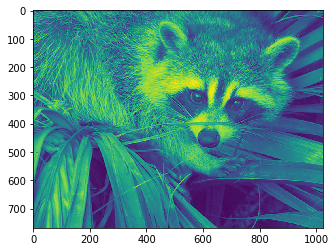

In [3]:
face = misc.face()
data = face[:,:,0] / 255
plt.imshow(data);

In [4]:
data.shape

(768, 1024)

## Decompositions

First we use a canned PCA routine as a baseline for image compression:

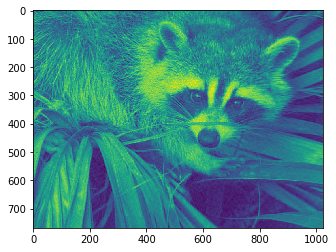

In [5]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
approx = pca.inverse_transform(pca.fit_transform(data))
plt.imshow(approx);

The resulting image is almost indistinguishable from the original.

Next, we illustrate some of the image compression methods we have implemented:

In [6]:
def plot_approx_array(rank):
    fig, ax = plt.subplots(1,5, figsize=(15,2.5))

    # Original Data
    ax[0].imshow(data)
    ax[0].set_xlabel('Original data')

    # Singular Value Decomposition
    start = perf_counter()
    ax[1].imshow(svd_rank_k(data, rank))
    ax[1].set_xlabel('Singular Value Decomposition')
    print(f'SVD: {perf_counter() - start}')

    # Randomized SVD
    start = perf_counter()
    ax[2].imshow(random_svd_rank_k(data, rank))
    ax[2].set_xlabel('Randomized SVD')
    print(f'RSVD: {perf_counter() - start}')

    # Interpolative Decomposition
    start = perf_counter()
    ax[3].imshow(id_rank_k(data, rank))
    ax[3].set_xlabel('Interpolative Decomposition')
    print(f'ID: {perf_counter() - start}')

    # Randomized ID
    start = perf_counter()
    ax[4].imshow(random_id_rank_k(data, rank))
    ax[4].set_xlabel('Randomized ID')
    print(f'RID: {perf_counter() - start}')

    plt.suptitle(f'Rank-{rank} Approximations')

SVD: 0.3809731999999997
RSVD: 0.03944690000000062
ID: 0.1955050999999992
RID: 0.0467588000000001


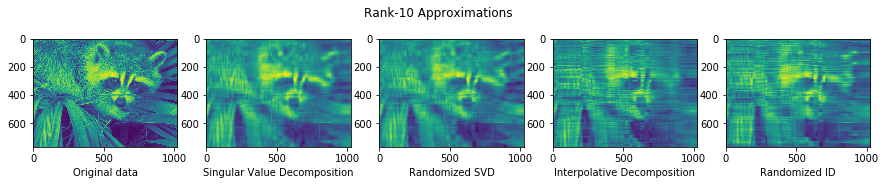

In [7]:
plot_approx_array(10)

SVD: 0.3748912999999998
RSVD: 0.09323069999999944
ID: 0.17015970000000014
RID: 0.05221270000000011


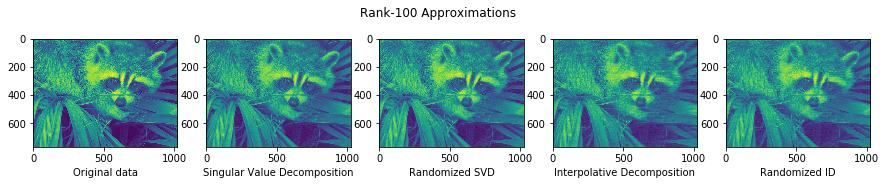

In [8]:
plot_approx_array(100)

We can see that a higher-rank matrix approximation leads to a more faithful image approximation. A higher-rank matrix holds more meaningful data than a lower-rank one, since it has more independent columns/rows.

We also see that the randomized methods are comparable to their deterministic variants in quality, while being much more efficient! This is a prime example of the benefits of using randomness in algorithms.

## Calculating Statistics

Here, we vary the rank k of the approximation and analyze the quality of the resulting compressed images:

In [9]:
k_domain = np.concatenate(([1, 2, 5, 10], np.arange(20, 400, step=40), [400, 420, 440]))

error_svd = np.empty(k_domain.shape[0])
error_id = np.empty(k_domain.shape[0])
abs_svd = np.empty(k_domain.shape[0])
abs_id = np.empty(k_domain.shape[0])

for i,val in enumerate(tqdm(k_domain)):
    abs_svd[i] = np.linalg.norm(data - svd_rank_k(data, val))
    abs_id[i] = np.linalg.norm(data - id_rank_k(data, val))
    error_svd[i] =  abs_svd[i]/ np.linalg.norm(data)
    error_id[i] = abs_id[i]/ np.linalg.norm(data)

error_random_svd = np.empty((8,k_domain.shape[0]))
error_random_id = np.empty((8, k_domain.shape[0]))

iterations = 10

for i,val in enumerate(tqdm(k_domain)):
    err_rsvd = np.empty((iterations,2))
    err_rid = np.empty((iterations,2))
    
    for j in range(iterations):
        abs_rsvd = np.linalg.norm(data - random_svd_rank_k(data,val))
        abs_rid = np.linalg.norm(data - random_id_rank_k(data,val))
        err_rsvd[j][0] = abs_rsvd / np.linalg.norm(data)
        err_rid[j][0] = abs_rid / np.linalg.norm(data)
        err_rsvd[j][1] = (abs_rsvd - abs_svd[i])/abs_svd[i]
        err_rid[j][1] = (abs_rid - abs_id[i])/abs_id[i]
    
    error_random_svd[0][i] = np.quantile(err_rsvd[:,0], 0.25)
    error_random_svd[1][i] = np.median(err_rsvd[:,0])
    error_random_svd[2][i] = np.quantile(err_rsvd[:,0], 0.75)
    error_random_svd[3][i] = np.mean(err_rsvd[:,0])
    error_random_svd[4][i] = np.std(err_rsvd[:,0])
    error_random_svd[5][i] = np.min(err_rsvd[:,0])
    error_random_svd[6][i] = np.max(err_rsvd[:,0])
    error_random_svd[7][i] = np.mean(err_rsvd[:,1])
   
    error_random_id[0][i] = np.quantile(err_rid[:,0], 0.25)
    error_random_id[1][i] = np.median(err_rid[:,0])
    error_random_id[2][i] = np.quantile(err_rid[:,0], 0.75)
    error_random_id[3][i] = np.mean(err_rid[:,0])
    error_random_id[4][i] = np.std(err_rid[:,0])
    error_random_id[5][i] = np.min(err_rid[:,0])
    error_random_id[6][i] = np.max(err_rid[:,0])
    error_random_id[7][i] = np.mean(err_rid[:,1])

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:34<00:00,  2.04s/it]


## Display results

Text(0.5, 1.0, 'Error in Various Approximations')

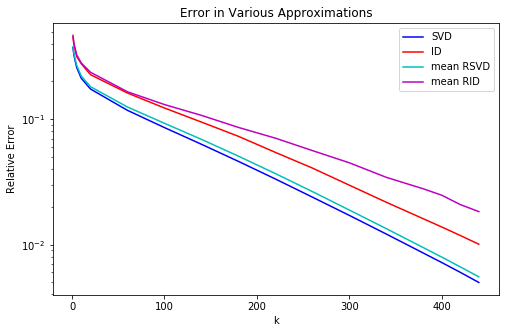

In [10]:
fig, ax = plt.subplots(1, figsize=(8,5))

ax.plot(k_domain, error_svd, c='b', label='SVD')
ax.plot(k_domain, error_id, c='r', label='ID')
ax.plot(k_domain, error_random_svd[3], c='c', label='mean RSVD')
ax.plot(k_domain, error_random_id[3], c='m', label='mean RID')
ax.set_xlabel('k')
ax.set_ylabel('Relative Error')
ax.set_yscale('log')
ax.legend(loc='upper right')
ax.set_title('Error in Various Approximations')

Note that this graph is logarithmically scaled, so the approximation really is quite good. For example, a rank-100 approximation of the (at most) 768-rank original image is about 90% accurate.

In [11]:
org_k_domain = k_domain
org_error_random_svd = error_random_svd
org_error_random_id = error_random_id

In [12]:
level = 3
k_domain = k_domain[-level:]
error_random_svd = error_random_svd[:,-level:]
error_random_id = error_random_id[:,-level:]

Text(0.5, 1.0, "Randomized ID 'continuous boxplot'")

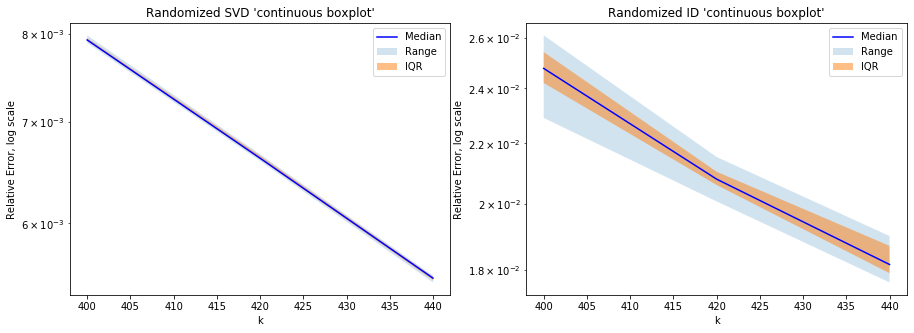

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(k_domain, error_random_svd[1], c='b', label='Median')
ax[0].fill_between(k_domain, error_random_svd[6],error_random_svd[5], alpha=0.2, label='Range')
ax[0].fill_between(k_domain, error_random_svd[2],error_random_svd[0], alpha=0.5, label='IQR')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error, log scale')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Randomized SVD \'continuous boxplot\'')

ax[1].plot(k_domain, error_random_id[1], c='b', label='Median')
ax[1].fill_between(k_domain, error_random_id[6],error_random_id[5], alpha=0.2, label='Range')
ax[1].fill_between(k_domain, error_random_id[2],error_random_id[0], alpha=0.5, label='IQR')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized ID \'continuous boxplot\'')

This graph lets us see the difference in accuracy and precision between RSVD and RID.

The accuracy of RSVD is better than that of RID, but what is arguably more noteworthy is the remarkable precision of RSVD. The RID plot has some level of variance, but in the RSVD plot, we can barely even see the faint outline of the range -- that's how precise it is.

## Timing Algorithms

In [ ]:
time_did = np.empty(org_k_domain.shape[0])
time_dsvd = np.empty(org_k_domain.shape[0])
time_rsvd = np.empty(org_k_domain.shape[0])
time_rid = np.empty(org_k_domain.shape[0])

N = 10 # Number of iterations to mitigate caching effects

for i,val in enumerate(tqdm(org_k_domain)):
    #time svd
    start = perf_counter()
    for n in range(N):
        svd_rank_k(data,val)
    end = perf_counter()
    time_dsvd[i] = (end - start)/N
    #time id
    start = perf_counter()
    for n in range(N):
        id_rank_k(data,val)
    end = perf_counter()
    time_did[i] = (end - start)/N
    #time rsvd
    start = perf_counter()
    for n in range(N):
        random_svd_rank_k(data, val)
    end = perf_counter()
    time_rsvd[i]= ((end - start)/N)/time_dsvd[i]
    #time rid
    start = perf_counter()
    for n in range(N):
        random_id_rank_k(data,val)
    end = perf_counter()
    time_rid[i] = ((end - start)/N)/time_did[i]   

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [02:01<00:09,  9.07s/it]

## Display Results

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

#ID Plot
lns1 = ax[0].plot(org_k_domain, org_error_random_id[7], c='m',label = 'Error')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
ax[0].set_title('Random ID Error and Time Relative to Deterministic ID')

ax1=ax[0].twinx()
ax1.set_ylabel('Relative Time')
lns2 = ax1.plot(org_k_domain,time_rid,c='b',label = 'Time')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0)

#SVD Plot
lns3 = ax[1].plot(org_k_domain, org_error_random_svd[7], c='m',label = 'Error')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error')
ax[1].set_title('Random SVD Error and Time Relative to Deterministic SVD')

ax2=ax[1].twinx()
ax2.set_ylabel('Relative Time')
lns4 = ax2.plot(org_k_domain,time_rsvd,c='b',label = 'Time')
ln = lns3+ lns4
lns5 = [l.get_label() for l in ln]
ax[1].legend(ln,lns5,loc=0)

The above results show us that as the value of $k$ increases for the low-rank ID approximation that the error for our deterministic method will decrease at a faster rate then the randomized method, thus giving us an increasing error curve. It is also shown that as $k$ increases, the error for deterministic and randomized SVD will decrease at similar rates, causing an upwards trend in the graph above. As expected, as the rank increases our relative time to run these methods increases.

#### Check out our other notebooks to see more examples of random projection in action!